In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ESE5460-Project/Work/Nob/code
!pwd

/content/drive/.shortcut-targets-by-id/13hnDcatKFcfNMCSS--_Sf5sg3YAM7J4e/ESE5460-Project/Work/Nob/code
/content/drive/.shortcut-targets-by-id/13hnDcatKFcfNMCSS--_Sf5sg3YAM7J4e/ESE5460-Project/Work/Nob/code


In [3]:
!pip install -qq timm
!pip install -qq einops
!pip install -qq thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
from datasets import build_dataset
from torchvision import datasets, transforms
import swin
import vae
import numpy as np
import torch
from torchvision.transforms.functional import rgb_to_grayscale
import utils
from IPython.display import display, clear_output
import time

# Import data

In [5]:
import os
import json

from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder, default_loader

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import create_transform

def build_dataset(is_train, data_path, input_size, color_jitter, aa, train_interpolation, reprob, remode, recount):
    transform = build_transform(is_train, input_size, color_jitter, aa, train_interpolation, reprob, remode, recount)

    dataset = datasets.CIFAR100(data_path, train=is_train, transform=transform, download=True)
    nb_classes = 100

    return dataset, nb_classes

def build_transform(is_train, input_size, color_jitter, aa, train_interpolation, reprob, remode, recount):
    resize_im = input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=color_jitter,
            auto_augment=aa,
            interpolation=train_interpolation,
            re_prob=reprob,
            re_mode=remode,
            re_count=recount,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                input_size, padding=4)
        return transform

    t = []
    if resize_im:
        size = int((256 / 224) * input_size)
        t.append(
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))


    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))

    return transforms.Compose(t)

In [6]:
dataset = build_dataset(is_train=False, data_path='../data', input_size = 224, color_jitter= 0.4, aa = 'rand-m9-mstd0.5-inc1',
                           train_interpolation='bicubic', reprob=0.25, remode='pixel',recount=1)
raw_cifar = datasets.CIFAR100('../data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


# Run the saved model

## Reconstruction model with the encoder-decoder

In [7]:
reconstruct_model = swin.Swin_T_reconstruct(100).cuda()
reconstruct_model.load_state_dict(torch.load('/content/drive/MyDrive/ESE5460-Project/Work/Nob/checkpoint_reconstruct_separate_losses_50ep_batchsz128_lr1e-3.pth')['model'])
device = torch.device('cuda')
criterion = utils.loss_function_reconstruct()

encoder = vae.Encoder(input_dim=224, hidden_dim=96, latent_dim=512)
decoder = vae.Decoder(latent_dim=512, hidden_dim = 96, output_dim = 224)

reconstruct_model_vae = vae.Model(Encoder=encoder, Decoder=decoder, device=device).cuda()
reconstruct_model_vae.load_state_dict(torch.load('/content/drive/MyDrive/ESE5460-Project/Work/Nob/checkpoint_50ep_VAE.pth')['model'])
device = torch.device('cuda')
criterion_vae = utils.loss_function_reconstruct()

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.008696
Block Initial Type: W, drop_path_rate:0.017391
Block Initial Type: SW, drop_path_rate:0.026087
Block Initial Type: W, drop_path_rate:0.034783
Block Initial Type: SW, drop_path_rate:0.043478
Block Initial Type: W, drop_path_rate:0.052174
Block Initial Type: SW, drop_path_rate:0.060870
Block Initial Type: W, drop_path_rate:0.069565
Block Initial Type: SW, drop_path_rate:0.078261
Block Initial Type: W, drop_path_rate:0.086957
Block Initial Type: W, drop_path_rate:0.095652
Block Initial Type: W, drop_path_rate:0.104348
Block Initial Type: SW, drop_path_rate:0.113043
Block Initial Type: W, drop_path_rate:0.121739
Block Initial Type: SW, drop_path_rate:0.130435
Block Initial Type: W, drop_path_rate:0.139130
Block Initial Type: SW, drop_path_rate:0.147826
Block Initial Type: W, drop_path_rate:0.156522
Block Initial Type: SW, drop_path_rate:0.165217
Block Initial Type: W, drop_path_rate:0.173913
Bloc

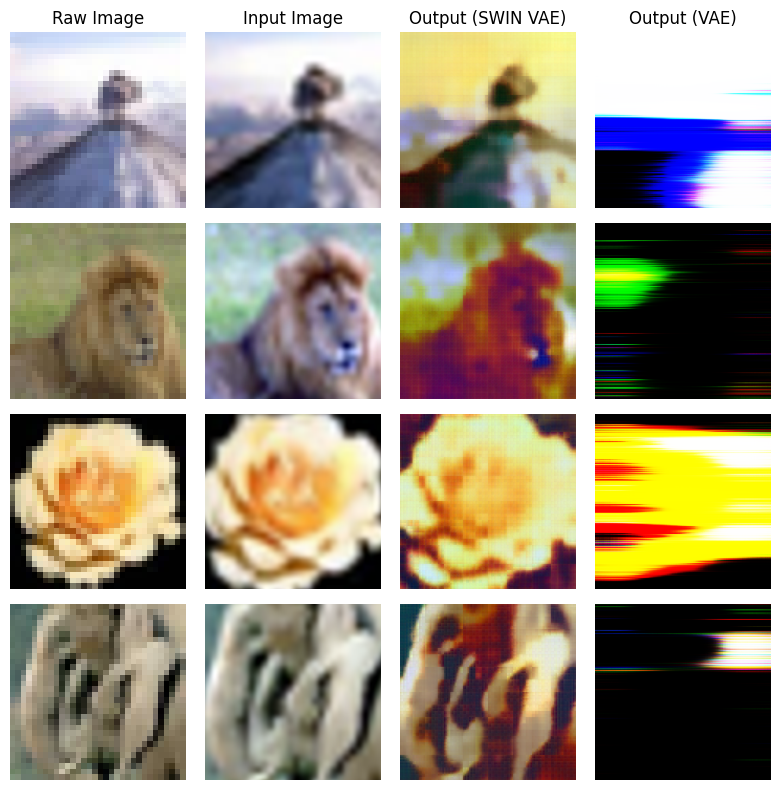

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(8,8))
axes = axes.flatten()
# plt.show(block=False)
count = 0
idx = [0, 15, 20, 500]
for j in idx:

    # SWIN
    img_hat, mu, sigma = reconstruct_model(dataset[0][j][0].unsqueeze(0).cuda()) # 3, 224, 224
    loss, recon, KLD = criterion(dataset[0][j][0].unsqueeze(0).cuda(), img_hat, mu, sigma)
    b, c, h, w = img_hat.size()
    loss /= (b*c*h*w)

    # vae
    img_hat_vae, mu_vae, sigma_vae = reconstruct_model_vae(dataset[0][j][0].unsqueeze(0).cuda()) # 3, 224, 224
    loss_vae, recon_vae, KLD_vae = criterion_vae(dataset[0][j][0].unsqueeze(0).cuda(), img_hat_vae, mu, sigma)
    b, c, h, w = img_hat.size()
    loss /= (b*c*h*w)

    resize = transforms.Resize((32,32))
    to_tensor = transforms.ToTensor()

    # Convert tensors to numpy arrays
    img1_np = dataset[0][j][0].permute(1, 2, 0).numpy()  # Channels last for matplotlib
    img1_np = to_tensor(raw_cifar[j][0]).permute(1, 2, 0).numpy()

    # img2_np = dataset[0][j][0].permute(1, 2, 0).numpy()  # Channels last for matplotlib

    # img3_np = img_hat.squeeze().detach().cpu().permute(1, 2, 0).numpy()


    img2_np = dataset[0][j][0]  # Channels last for matplotlib
    c, h, w = img2_np.size()
    img2_np = img2_np.view(img2_np.size(0), -1)
    img2_np -= img2_np.min(1, keepdim=True)[0]
    img2_np /= img2_np.max(1, keepdim=True)[0]
    img2_np = img2_np.view(c, h, w).permute(1, 2, 0).numpy()

    img3_np = img_hat.squeeze()
    c, h, w = img3_np.size()
    img3_np = img3_np.view(img3_np.size(0), -1)
    img3_np -= img3_np.min(1, keepdim=True)[0]
    img3_np /= img3_np.max(1, keepdim=True)[0]
    # img3_np -= img3_np.min()
    # img3_np /= img3_np.max()
    img3_np = img3_np.view(c, h, w).detach().cpu().permute(1, 2, 0).numpy()

    img4_np = img_hat_vae.squeeze()
    c, h, w = img4_np.size()
    img4_np = img4_np.view(img4_np.size(0), -1)
    img4_np -= img4_np.min(1, keepdim=True)[0]
    img4_np /= img4_np.max(1, keepdim=True)[0]
    img4_np = img4_np.view(c, h, w).detach().cpu().permute(1, 2, 0).numpy()

    # Plot the first image
    axes[count].clear()
    axes[count].imshow(img1_np)
    if (count == 0):
        axes[count].set_title('Raw Image')

    count += 1

    # Plot the second image
    axes[count].clear()
    axes[count].imshow(img2_np)
    if (count == 1):
        axes[1].set_title('Input Image')

    count += 1

    # Plot the third image
    axes[count].clear()
    axes[count].imshow(img3_np)
    if (count == 2):
        axes[count].set_title('Output (SWIN VAE)')

    count += 1

    # Plot the fourth image
    axes[count].clear()
    axes[count].imshow(img4_np)
    if (count == 3):
        axes[count].set_title('Output (VAE)')

    count += 1

    # fig.suptitle(f'Comparison with loss = {loss}', size=14, y = 0.78)
    # Hide the axes
    for ax in axes:
        ax.axis('off')

    # Display the current images using IPython.display
    fig.tight_layout()
    # display(fig)
    # clear_output(wait=True)

    # Introduce a delay
    # time.sleep(1)

# plt.close()
plt.show()



In [52]:
import ast

data = []
with open('../log/log_reconstruct_separate_losses_50ep_batchsz128_lr1e-3.txt', 'r') as file:
    for line in file:
        data.append(ast.literal_eval(line))

train_size = 50000
test_size = 10000

epochs = [entry['epoch'] for entry in data]
train_lr = [entry['train_lr'] for entry in data]
train_loss = [entry['train_loss'] / train_size for entry in data]
test_loss = [entry['test_loss'] / test_size for entry in data]
train_recon = [entry['train_reproduction_loss'] / train_size for entry in data]
test_recon = [entry['test_reproduction_loss'] / test_size for entry in data]
train_kld = [entry['train_KLD'] / train_size for entry in data]
test_kld = [entry['test_KLD'] / test_size for entry in data]

print(f'Min loss train: {min(train_loss)}')
print(f'Min loss test: {min(test_loss)}')
print(f'Min reconstruction loss train: {min(train_recon)}')
print(f'Min reconstruction loss test: {min(test_recon)}')
print(f'Min KL Divergence loss train: {min(train_kld)}')
print(f'Min KL Divergence loss test: {min(test_kld)}')


data_vae = []
with open('../log/log_50ep_VAE.txt', 'r') as file:
    for line in file:
        data_vae.append(ast.literal_eval(line))

epochs_vae = [entry['epoch'] for entry in data_vae]
train_lr_vae = [entry['train_lr'] for entry in data_vae]
train_loss_vae = [entry['train_loss'] / train_size for entry in data_vae]
test_loss_vae = [entry['test_loss'] / test_size for entry in data_vae]
train_recon_vae = [entry['train_reproduction_loss'] / train_size for entry in data_vae]
test_recon_vae = [entry['test_reproduction_loss'] / test_size for entry in data_vae]
train_kld_vae = [entry['train_KLD'] / train_size for entry in data_vae]
test_kld_vae = [entry['test_KLD'] / test_size for entry in data_vae]

print(f'Min loss train: {min(train_loss_vae)}')
print(f'Min loss test: {min(test_loss_vae)}')
print(f'Min reconstruction loss train: {min(train_recon_vae)}')
print(f'Min reconstruction loss test: {min(test_recon_vae)}')
print(f'Min KL Divergence loss train: {min(train_kld_vae)}')
print(f'Min KL Divergence loss test: {min(test_kld_vae)}')

Min loss train: 1.1209784098160573e-05
Min loss test: 5.466231243519843e-05
Min reconstruction loss train: 1.1119750044284722e-05
Min reconstruction loss test: 5.415764700008344e-05
Min KL Divergence loss train: 8.941934353266007e-08
Min KL Divergence loss test: 4.87866912838779e-07
Min loss train: 1.3321772165787526e-05
Min loss test: 6.654060512781144e-05
Min reconstruction loss train: 1.31824464064378e-05
Min reconstruction loss test: 6.584335833787917e-05
Min KL Divergence loss train: 4.819644644904213e-08
Min KL Divergence loss test: 2.6071063592098653e-07


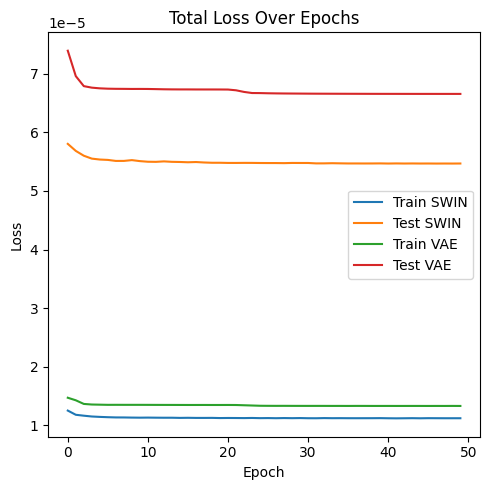

In [11]:
plt.figure(figsize=(5, 5))

# Plot Loss
# plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train SWIN')
plt.plot(epochs, test_loss, label='Test SWIN')
plt.plot(epochs, train_loss_vae, label='Train VAE')
plt.plot(epochs, test_loss_vae, label='Test VAE')
plt.title('Total Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# # Plot Learning Rate
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_lr, label='Learning Rate')
# plt.title('Learning Rate Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

plt.tight_layout()
plt.show()


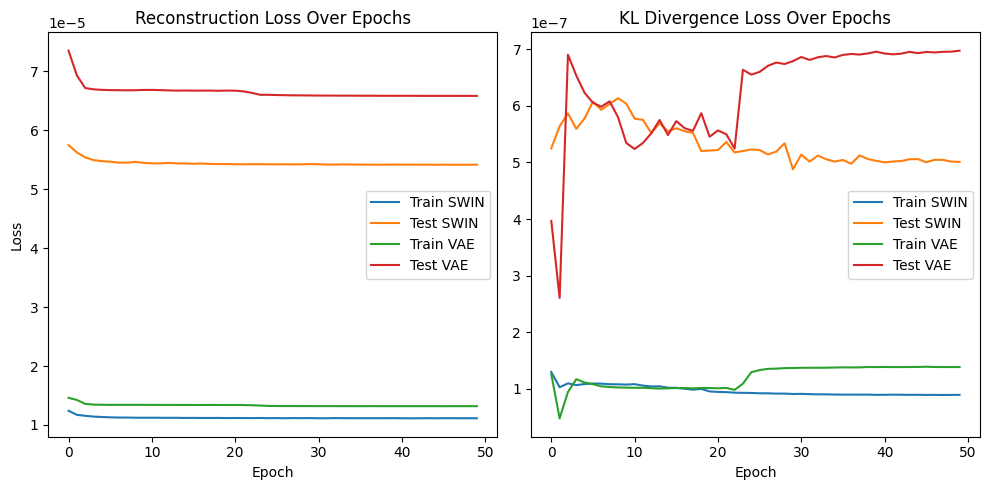

In [54]:
plt.figure(figsize=(10, 5))

# Plot Reconstruction Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_recon, label='Train SWIN')
plt.plot(epochs, test_recon, label='Test SWIN')
plt.plot(epochs, train_recon_vae, label='Train VAE')
plt.plot(epochs, test_recon_vae, label='Test VAE')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot KL Divergence Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_kld, label='Train SWIN')
plt.plot(epochs, test_kld, label='Test SWIN')
plt.plot(epochs, train_kld_vae, label='Train VAE')
plt.plot(epochs, test_kld_vae, label='Test VAE')
plt.title('KL Divergence Loss Over Epochs')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Comparison of 3 SWIN configurations

In [26]:
import ast

train_size = 50000
test_size = 10000

# Complex SWIN_T: configuration 2,2,10,2
print('====== Complex Swin ======')
data = []
with open('../log/log_300ep_lr1e-3_22102.txt', 'r') as file:
    for line in file:
        data.append(ast.literal_eval(line))


epochs = [entry['epoch'] for entry in data] # same for all configurations
train_lr_complex = [entry['train_lr'] for entry in data] # same for all configurations

train_acc_complex = [entry['train_acc1'] for entry in data]
test_acc_complex = [entry['test_acc1'] for entry in data]
train_loss_complex = [entry['train_loss'] / train_size for entry in data]
test_loss_complex = [entry['test_loss'] / test_size for entry in data]

print(f'Min loss train: {min(train_loss_complex)}')
print(f'Min loss test: {min(test_loss_complex)}')
print(f'Max acc train: {max(train_acc_complex)}')
print(f'Max acc test: {max(test_acc_complex)}')



# Original SWIN_T: configuration 2,2,6,2
print('====== Original Swin ======')
data = []
with open('../log/log_300ep_lr1e-3_2262.txt', 'r') as file:
    for line in file:
        data.append(ast.literal_eval(line))

train_acc = [entry['train_acc1'] for entry in data]
test_acc = [entry['test_acc1'] for entry in data]
train_loss = [entry['train_loss'] / train_size for entry in data]
test_loss = [entry['test_loss'] / test_size for entry in data]

print(f'Min loss train: {min(train_loss)}')
print(f'Min loss test: {min(test_loss)}')
print(f'Max acc train: {max(train_acc)}')
print(f'Max acc test: {max(test_acc)}')

# simple SWIN_T: configuration 2,2,2,2
print('====== Simple Swin ======')
data = []
with open('../log/log_300ep_lr1e-3_2222.txt', 'r') as file:
    for line in file:
        data.append(ast.literal_eval(line))

train_acc_simple = [entry['train_acc1'] for entry in data]
test_acc_simple = [entry['test_acc1'] for entry in data]
train_loss_simple = [entry['train_loss'] / train_size for entry in data]
test_loss_simple = [entry['test_loss'] / test_size for entry in data]

print(f'Min loss train: {min(train_loss_simple)}')
print(f'Min loss test: {min(test_loss_simple)}')
print(f'Max acc train: {max(train_acc_simple)}')
print(f'Max acc test: {max(test_acc_simple)}')

====== Complex Swin ======
Min loss train: 2.931235962647658e-05
Min loss test: 9.650213301181794e-05
Max acc train: 81.8329326923077
Max acc test: 77.11
====== Original Swin ======
Min loss train: 3.042088343546941e-05
Min loss test: 9.704969212412834e-05
Max acc train: 80.1943108974359
Max acc test: 76.82
====== Simple Swin ======
Min loss train: 3.2857152889936396e-05
Min loss test: 9.67746701836586e-05
Max acc train: 76.47636217948718
Max acc test: 76.38


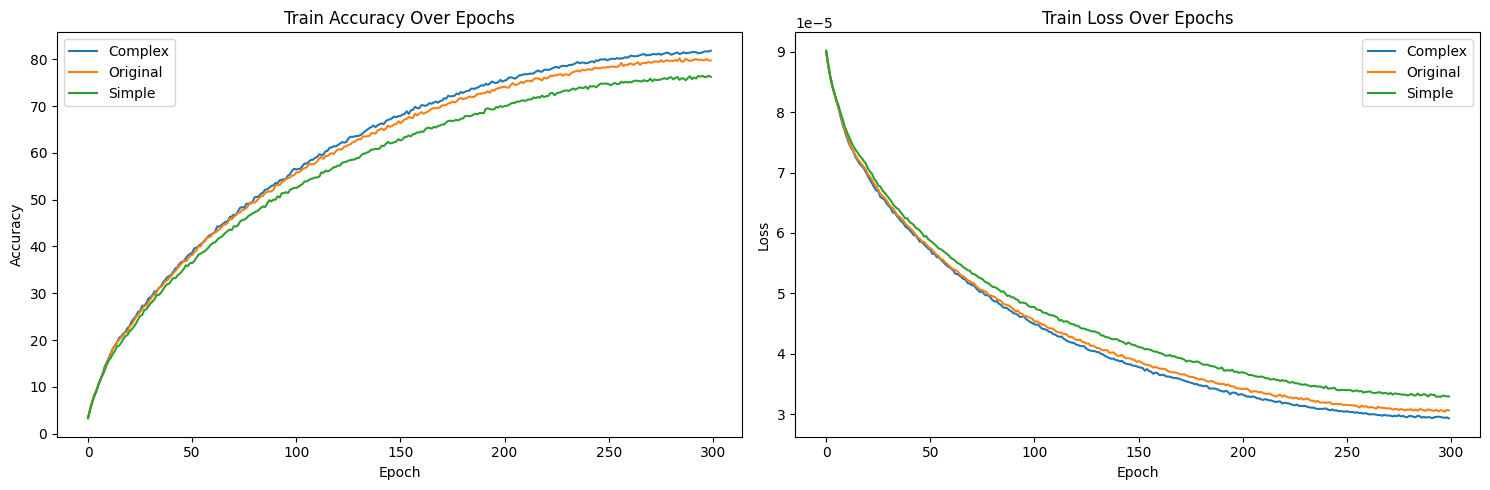

In [13]:
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_complex, label='Complex')

plt.plot(epochs, train_acc, label='Original')

plt.plot(epochs, train_acc_simple, label='Simple')

plt.title('Train Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_complex, label='Complex')

plt.plot(epochs, train_loss, label='Original')

plt.plot(epochs, train_loss_simple, label='Simple')

plt.title('Train Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

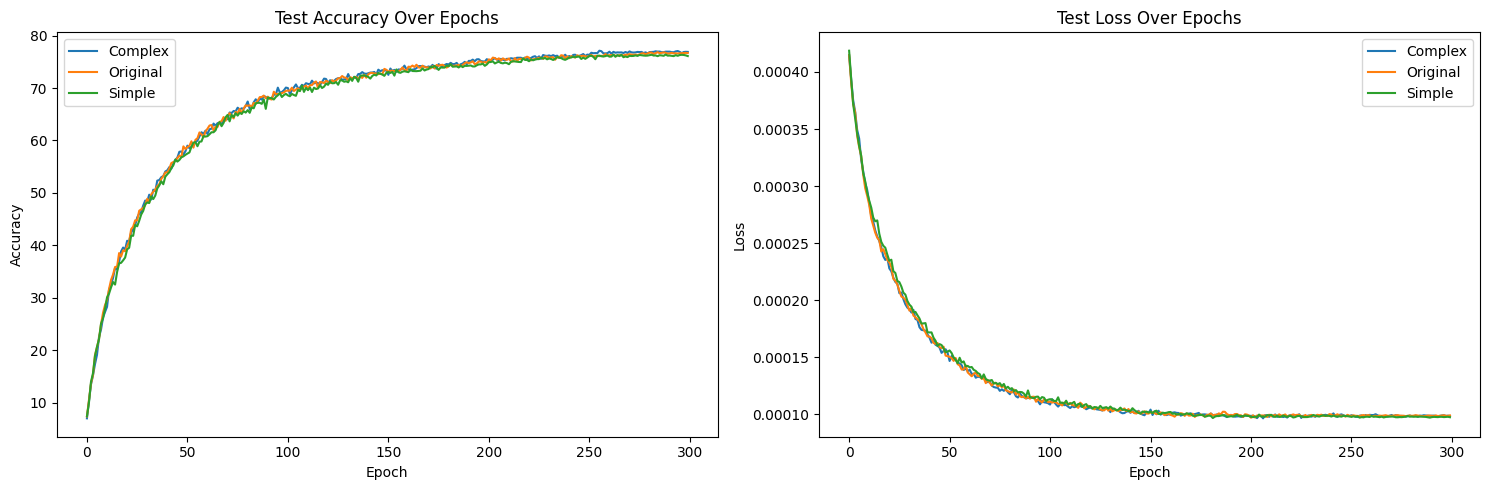

In [14]:
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)

plt.plot(epochs, test_acc_complex, label='Complex')

plt.plot(epochs, test_acc, label='Original')

plt.plot(epochs, test_acc_simple, label='Simple')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)

plt.plot(epochs, test_loss_complex, label='Complex')

plt.plot(epochs, test_loss, label='Original')

plt.plot(epochs, test_loss_simple, label='Simple')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

## Comparison of different activation functions

In [27]:
import ast

data_OG = []
with open('../log/log_300ep_lr1e-3_2222.txt', 'r') as file:
    for line in file:
        data_OG.append(ast.literal_eval(line))

train_size = 50000
test_size = 10000

print('====== GELU Original ======')
epochs_OG = [entry['epoch'] for entry in data_OG]
train_lr_OG = [entry['train_lr'] for entry in data_OG]

train_acc_OG = [entry['train_acc1'] for entry in data_OG]
test_acc_OG = [entry['test_acc1'] for entry in data_OG]
train_loss_OG = [entry['train_loss']/train_size for entry in data_OG]
test_loss_OG = [entry['test_loss']/test_size for entry in data_OG]

print(f'Min loss train: {min(train_loss_OG)}')
print(f'Min loss test: {min(test_loss_OG)}')
print(f'Max acc train: {max(train_acc_OG)}')
print(f'Max acc test: {max(test_acc_OG)}')

# GELU
data_GELU = []
print('====== GELU ======')
with open('../log/log_300ep_2222_GELU.txt', 'r') as file:
    for line in file:
        data_GELU.append(ast.literal_eval(line))

epochs_GELU = [entry['epoch'] for entry in data_GELU]
train_lr_GELU = [entry['train_lr'] for entry in data_GELU]

train_acc_GELU = [entry['train_acc1'] for entry in data_GELU]
test_acc_GELU = [entry['test_acc1'] for entry in data_GELU]
train_loss_GELU = [entry['train_loss']/train_size for entry in data_GELU]
test_loss_GELU = [entry['test_loss']/test_size for entry in data_GELU]

print(f'Min loss train: {min(train_loss_GELU)}')
print(f'Min loss test: {min(test_loss_GELU)}')
print(f'Max acc train: {max(train_acc_GELU)}')
print(f'Max acc test: {max(test_acc_GELU)}')

# ReLU
data_ReLU = []
print('====== ReLU ======')
with open('../log/log_300ep_2222_ReLU.txt', 'r') as file:
    for line in file:
        data_ReLU.append(ast.literal_eval(line))

epochs_ReLU = [entry['epoch'] for entry in data_ReLU]
train_lr_ReLU = [entry['train_lr'] for entry in data_ReLU]

train_acc_ReLU = [entry['train_acc1'] for entry in data_ReLU]
test_acc_ReLU = [entry['test_acc1'] for entry in data_ReLU]
train_loss_ReLU = [entry['train_loss']/train_size for entry in data_ReLU]
test_loss_ReLU = [entry['test_loss']/test_size for entry in data_ReLU]

print(f'Min loss train: {min(train_loss_ReLU)}')
print(f'Min loss test: {min(test_loss_ReLU)}')
print(f'Max acc train: {max(train_acc_ReLU)}')
print(f'Max acc test: {max(test_acc_ReLU)}')

# Swish
data_Swish = []
print('====== Swish ======')
with open('../log/log_300ep_2222_Swish.txt', 'r') as file:
    for line in file:
        data_Swish.append(ast.literal_eval(line))

epochs_Swish = [entry['epoch'] for entry in data_Swish]
train_lr_Swish = [entry['train_lr'] for entry in data_Swish]

train_acc_Swish = [entry['train_acc1'] for entry in data_Swish]
test_acc_Swish = [entry['test_acc1'] for entry in data_Swish]
train_loss_Swish = [entry['train_loss']/train_size for entry in data_Swish]
test_loss_Swish = [entry['test_loss']/test_size for entry in data_Swish]

print(f'Min loss train: {min(train_loss_Swish)}')
print(f'Min loss test: {min(test_loss_Swish)}')
print(f'Max acc train: {max(train_acc_Swish)}')
print(f'Max acc test: {max(test_acc_Swish)}')

====== GELU Original ======
Min loss train: 3.2857152889936396e-05
Min loss test: 9.67746701836586e-05
Max acc train: 76.47636217948718
Max acc test: 76.38
====== GELU ======
Min loss train: 3.193818876070854e-05
Min loss test: 0.0001046860656142235
Max acc train: 78.39342948717949
Max acc test: 75.19
====== ReLU ======
Min loss train: 3.3742579936981206e-05
Min loss test: 0.0001085419347882271
Max acc train: 75.30048076923077
Max acc test: 73.36
====== Swish ======
Min loss train: 3.4377291006919665e-05
Min loss test: 0.00010796970903873445
Max acc train: 74.8016826923077
Max acc test: 73.68


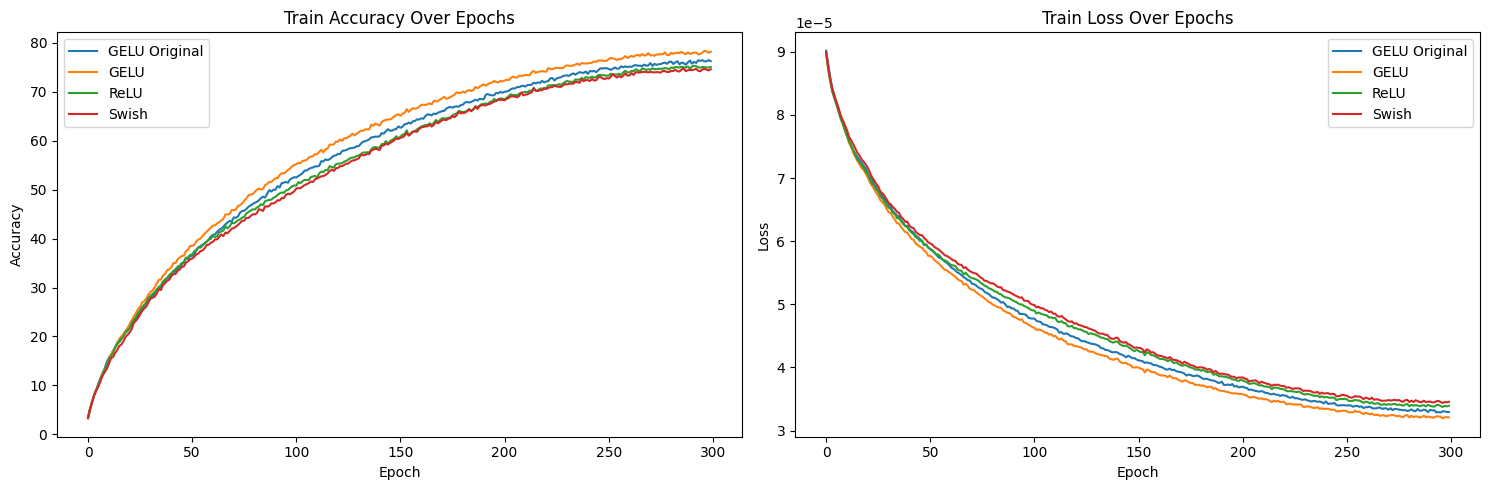

In [16]:
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_OG, train_acc_OG, label='GELU Original')

plt.plot(epochs_GELU, train_acc_GELU, label='GELU')

plt.plot(epochs_ReLU, train_acc_ReLU, label='ReLU')

plt.plot(epochs_Swish, train_acc_Swish, label='Swish')

plt.title('Train Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_OG, train_loss_OG, label='GELU Original')

plt.plot(epochs_GELU, train_loss_GELU, label='GELU')

plt.plot(epochs_ReLU, train_loss_ReLU, label='ReLU')

plt.plot(epochs_Swish, train_loss_Swish, label='Swish')

plt.title('Train Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# # Plot Learning Rate
# plt.subplot(1, 3, 3)
# plt.plot(epochs_complex, train_lr_complex, label='Learning Rate Complex')
# plt.plot(epochs, train_lr, label='Learning Rate')
# plt.title('Learning Rate Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

plt.tight_layout()
plt.show()

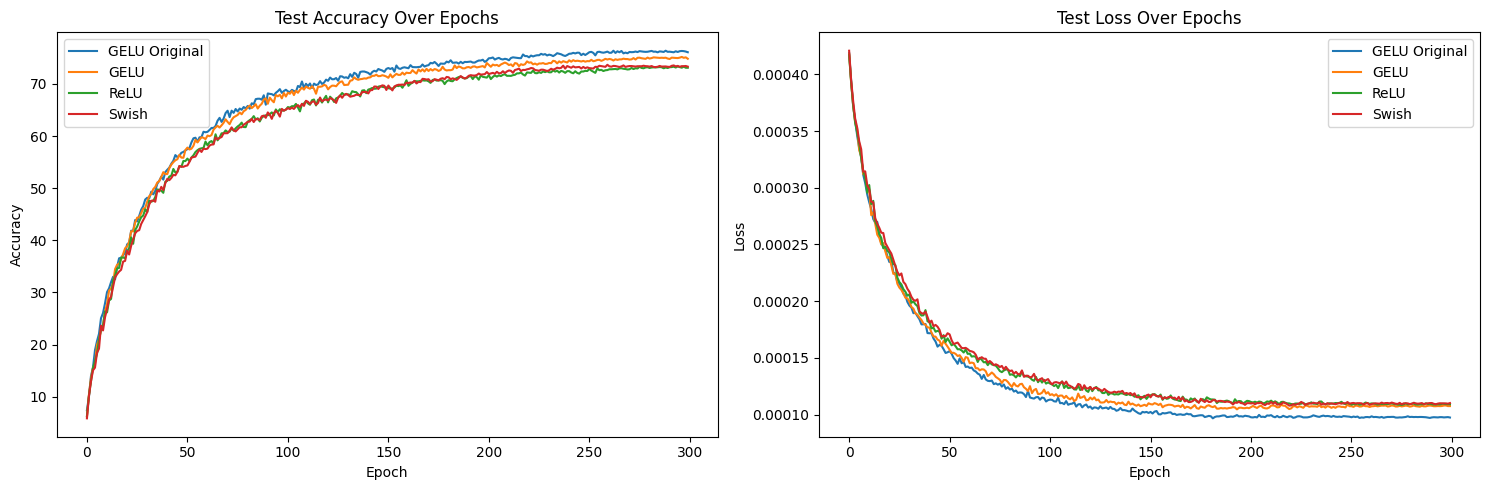

In [17]:
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)

plt.plot(epochs_OG, test_acc_OG, label='GELU Original')

plt.plot(epochs_GELU, test_acc_GELU, label='GELU')

plt.plot(epochs_ReLU, test_acc_ReLU, label='ReLU')

plt.plot(epochs_Swish, test_acc_Swish, label='Swish')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)

plt.plot(epochs_OG, test_loss_OG, label='GELU Original')

plt.plot(epochs_GELU, test_loss_GELU, label='GELU')

plt.plot(epochs_ReLU, test_loss_ReLU, label='ReLU')

plt.plot(epochs_Swish, test_loss_Swish, label='Swish')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# # Plot Learning Rate
# plt.subplot(1, 3, 3)
# plt.plot(epochs_complex, train_lr_complex, label='Learning Rate Complex')
# plt.plot(epochs, train_lr, label='Learning Rate')
# plt.title('Learning Rate Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

plt.tight_layout()
plt.show()